# Proyecto 1: Entrenamiento del Modelo

In [170]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, StringTensorType
import onnxruntime as ort

In [171]:
# Cargar Dataset

data = pd.read_csv("data/insurance.csv")

data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## EDA

In [172]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   str    
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   str    
 5   region    1338 non-null   str    
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), str(3)
memory usage: 73.3 KB


Text(0.5, 1.0, "Distribución de la variable objetivo 'charges'")

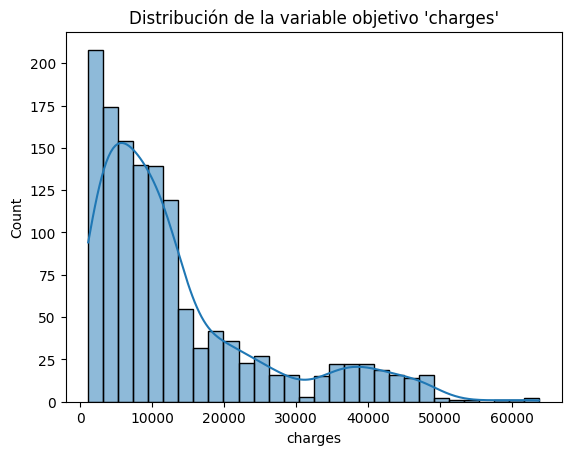

In [173]:
sns.histplot(data["charges"], kde=True)
plt.title("Distribución de la variable objetivo 'charges'")

In [174]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


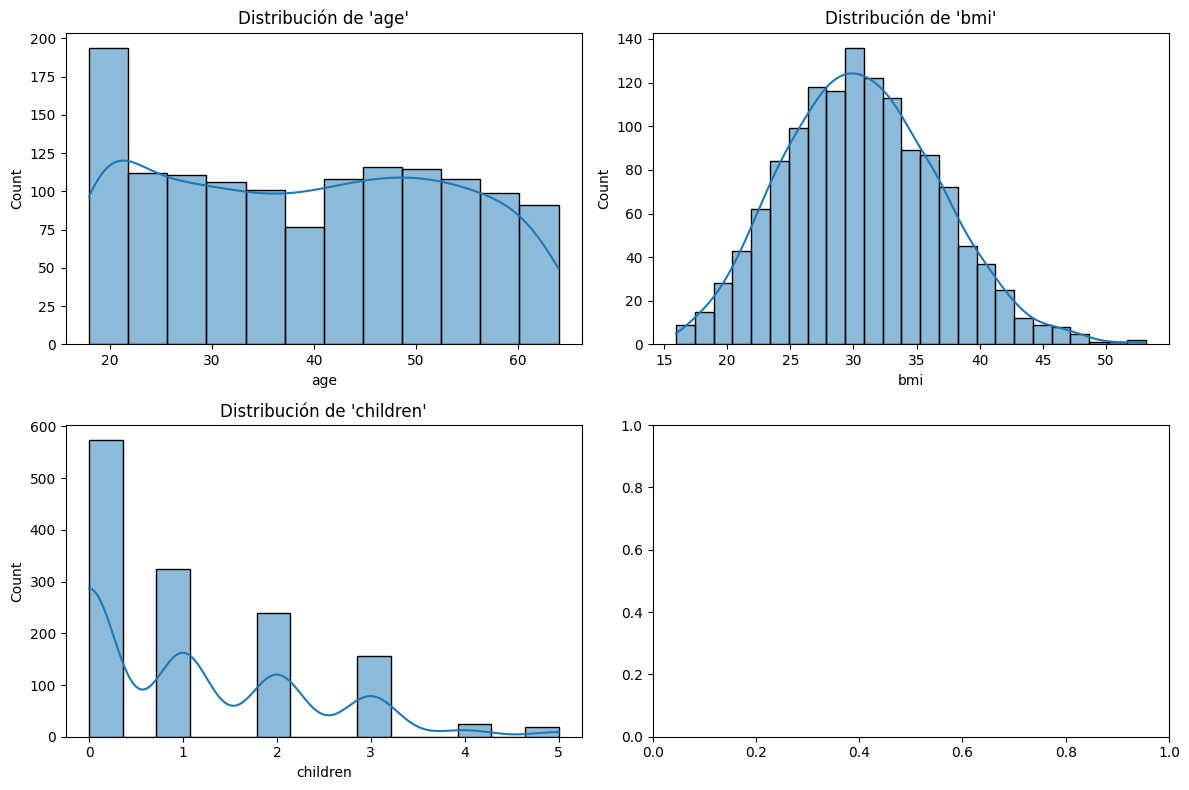

In [175]:
numerical_features = ["age", "bmi", "children"]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for ax, col in zip(axs.ravel(), numerical_features):
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(f'Distribución de \'{col}\'')

fig.tight_layout()

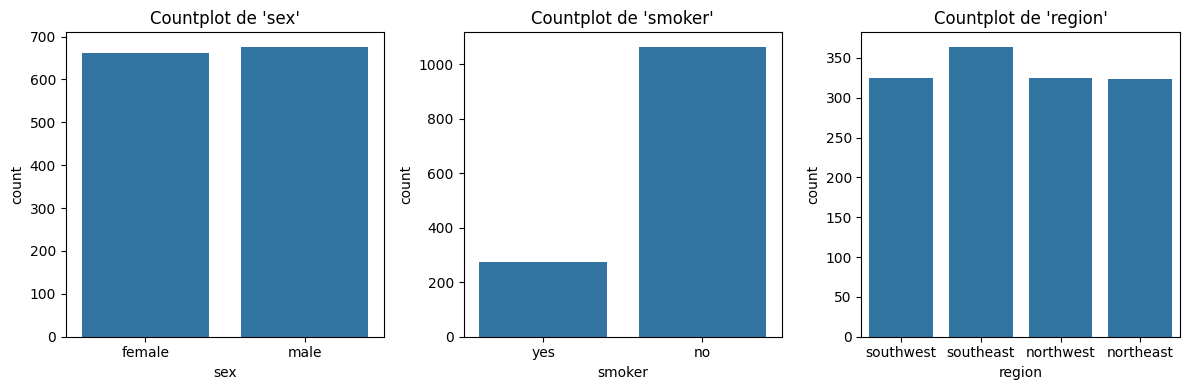

In [176]:
categorical_features = ['sex', 'smoker', 'region']

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for ax, col in zip(axs.ravel(), categorical_features):
    sns.countplot(data=data, x=col, ax=ax)
    ax.set_title(f'Countplot de \'{col}\'')

fig.tight_layout()

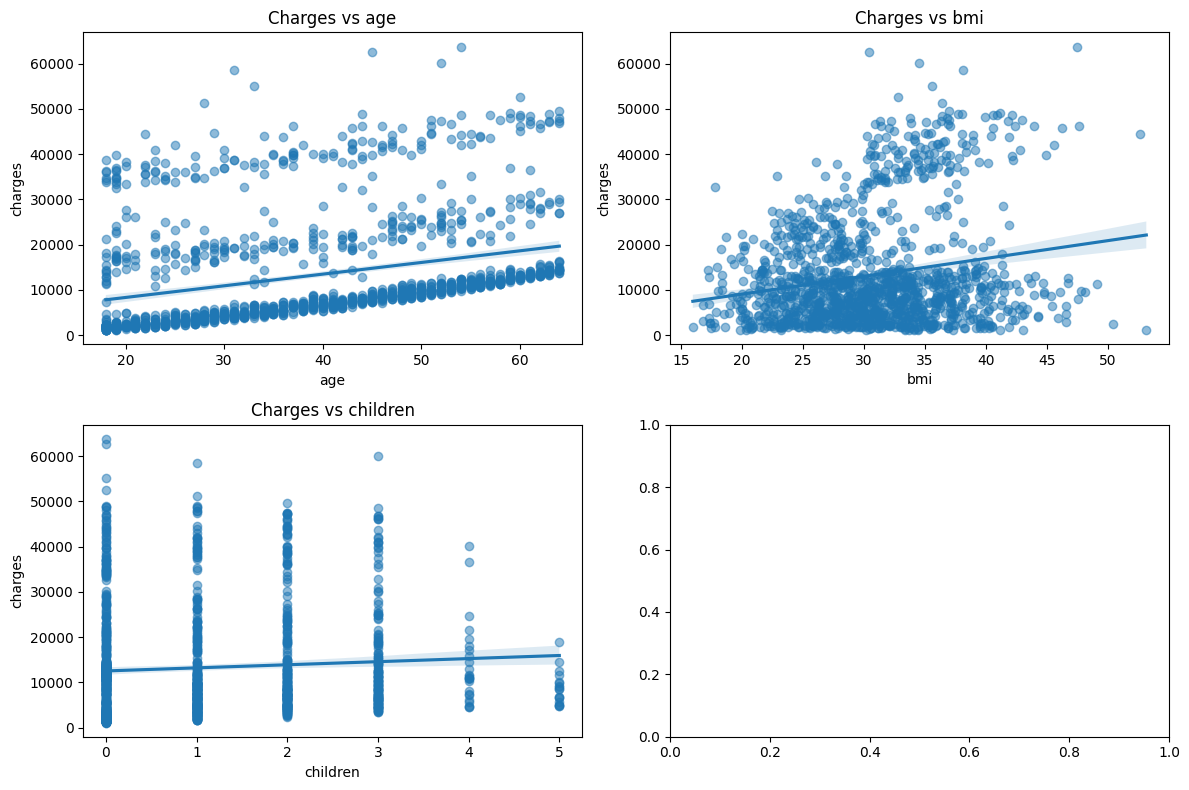

In [177]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for ax, col in zip(axs.ravel(), numerical_features):
    sns.regplot(data=data, x=col, y='charges', ax=ax, scatter_kws={'alpha':0.5})
    ax.set_title(f'Charges vs {col}')

fig.tight_layout()
plt.show()

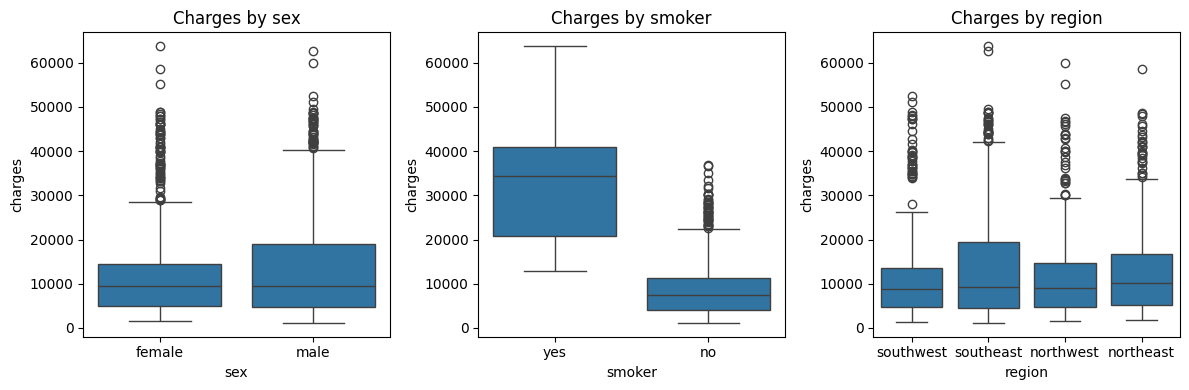

In [178]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for ax, col in zip(axs.ravel(), categorical_features):
    sns.boxplot(data=data, x=col, y='charges', ax=ax)
    ax.set_title(f'Charges by {col}')

fig.tight_layout()
plt.show()

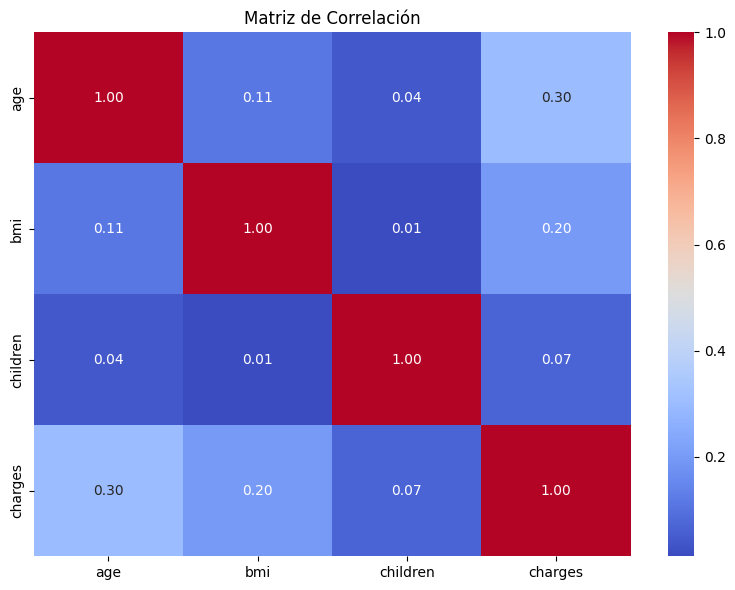

In [179]:
corr_matrix = data[numerical_features + ['charges']].corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

<Axes: >

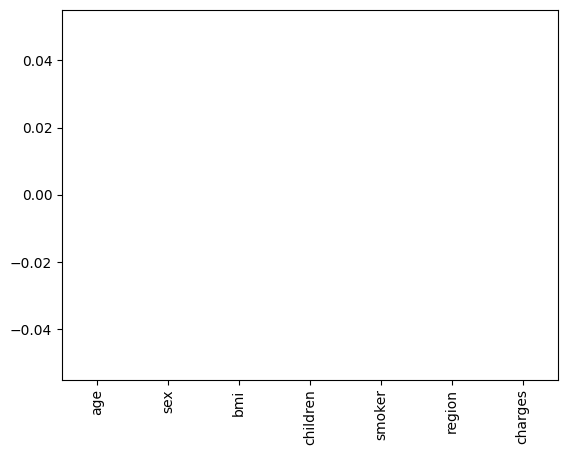

In [180]:
missing_counts = data.isnull().sum()
missing_counts.plot(kind='bar')

In [181]:
missing_percent = data.isnull().mean() * 100
missing_percent.sort_values(ascending=False)

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

### Conclusiones de EDA

A partir del análisis exploratorio de datos realizado, se observa que la variable de salida **`charges`** presenta un rango amplio y una distribución claramente sesgada a la izquierda, alejándose de una distribución normal gaussiana. Los valores bajos de cargos son mucho más frecuentes, mientras que conforme el valor de los cargos aumenta, su frecuencia disminuye considerablemente.

El conjunto de datos está compuesto por **tres variables numéricas** (`age`, `bmi`, `children`) y **tres variables categóricas** (`sex`, `smoker`, `region`).

#### Variables numéricas
- **`age`** presenta valores acotados y una distribución no gaussiana.
- **`bmi`** muestra una distribución aproximadamente gaussiana.
- **`children`** toma valores discretos entre 0 y 5 y no sigue una distribución normal.

Con base en estos hallazgos, se decidió aplicar las siguientes transformaciones:
- `age`: `StandardScaler` y `PowerTransformer`
- `bmi`: `StandardScaler`
- `children`: `StandardScaler` y `PowerTransformer`

#### Variables categóricas
- **`sex`** presenta una distribución prácticamente balanceada entre ambas categorías.
- **`smoker`** muestra una distribución altamente desbalanceada, donde la mayoría de los registros corresponden a personas no fumadoras.
- **`region`** tiene una distribución bastante uniforme entre las cuatro categorías, con una ligera mayor presencia de la región *southeast*.

Dado que ninguna de estas variables categóricas posee un orden intrínseco, se determinó aplicar **`OneHotEncoder`** en todos los casos:
- `sex`: OneHotEncoder
- `smoker`: OneHotEncoder
- `region`: OneHotEncoder

#### Hallazgos relevantes
- Se observa una tendencia creciente de los cargos conforme aumenta la edad.
- Existe un grupo de registros con cargos considerablemente elevados en personas con valores de `bmi` entre 30 y 40.
- Se aprecian diferencias en los cargos entre registros con 0 a 3 hijos frente a aquellos con 4 o 5 hijos, aunque esta diferencia podría estar influenciada por el tamaño reducido de muestra en los valores más altos.
- Los cargos entre hombres y mujeres son muy similares, con una ligera tendencia a cargos mayores en hombres.
- La variable **`smoker`** presenta una diferencia notable y consistente, donde los fumadores tienen cargos considerablemente más altos.
- Las cuatro regiones muestran distribuciones similares de cargos, aunque la región *southeast* presenta una ligera tendencia a cargos mayores.

Por otro lado, la matriz de correlación entre las variables numéricas, incluyendo la variable de salida, indica que **no existen relaciones lineales fuertes** entre dichas variables, lo cual sugiere la posible presencia de relaciones no lineales o interacciones entre características.

Finalmente, no se identificaron valores faltantes en ninguna de las variables, por lo que no fue necesario aplicar técnicas para manejo de estos casos.

## Preprocesamiento

In [182]:
preprocessing_pipeline = ColumnTransformer(
    transformers=[
        # Numéricas
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('power', PowerTransformer())
        ]), ['age', 'children']),

        ('num_bmi', Pipeline([
            ('scaler', StandardScaler())
        ]), ['bmi']),

        # Categóricas (SIN SimpleImputer)
        ('cat', OneHotEncoder(handle_unknown='ignore'), 
         ['sex', 'smoker', 'region'])
    ]
)

## Entrenamiento del Modelo

### Métrica objetivo

Se eligió el **Root Mean Squared Error (RMSE)** como métrica objetivo debido a que permite cuantificar el error promedio del modelo manteniendo las mismas unidades que la variable de salida, lo que facilita su interpretación.

Además, el RMSE penaliza de forma más severa los errores grandes, lo cual resulta deseable en este problema, ya que existen registros con cargos elevados cuya mala predicción tendría un impacto significativo. Por esta razón, el RMSE es una métrica adecuada para evaluar el desempeño y la capacidad de generalización de los modelos en este conjunto de datos.

In [183]:
x = data[numerical_features + categorical_features] 
y = data['charges']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

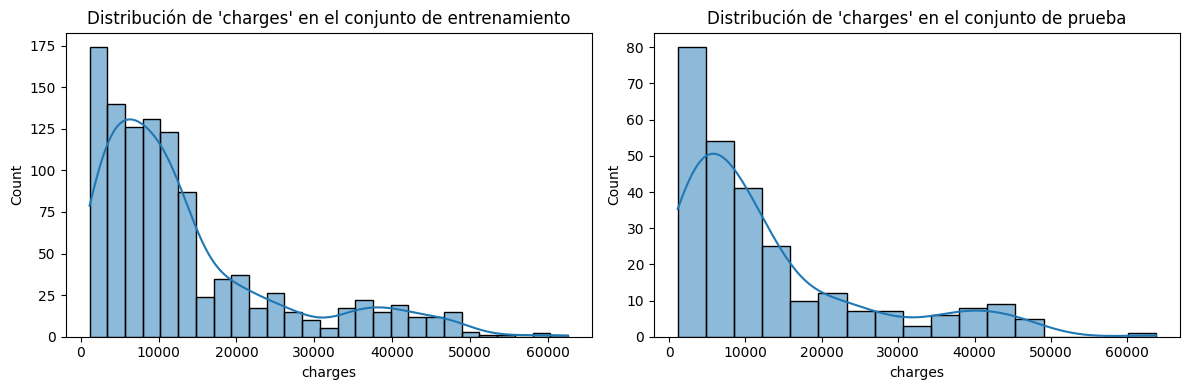

In [184]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(y_train, ax=axs[0], kde=True)
axs[0].set_title('Distribución de \'charges\' en el conjunto de entrenamiento')
sns.histplot(y_test, ax=axs[1], kde=True)
axs[1].set_title('Distribución de \'charges\' en el conjunto de prueba')
fig.tight_layout()

In [185]:
ridge_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', Ridge())
])

param_grid_ridge = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]
}

grid_ridge = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param_grid_ridge,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_ridge.fit(x_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...l', Ridge())])"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__alpha': [0.01, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >

In [186]:
lasso_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', Lasso(max_iter=5000))
])

param_grid_lasso = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10]
}

grid_lasso = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=param_grid_lasso,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_lasso.fit(x_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=5000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__alpha': [0.001, 0.01, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >

In [187]:
rf_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
}

grid_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_rf.fit(x_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__max_depth': [None, 10, ...], 'model__min_samples_split': [2, 5], 'model__n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and

In [188]:
best_ridge = grid_ridge.best_estimator_
best_lasso = grid_lasso.best_estimator_
best_rf    = grid_rf.best_estimator_

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

models = {
    'Ridge': best_ridge,
    'Lasso': best_lasso,
    'Random Forest': best_rf
}

results = []

for name, model in models.items():
    # Predicciones
    y_train_pred = model.predict(x_train)
    y_test_pred  = model.predict(x_test)
    
    # RMSE
    train_rmse = rmse(y_train, y_train_pred)
    test_rmse  = rmse(y_test, y_test_pred)
    
    results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Gap (Test - Train)': test_rmse - train_rmse
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Test RMSE')
results_df

,Model,Train RMSE,Test RMSE,Gap (Test - Train)
2,Random Forest,2752.507552,4517.392922,1764.885370
0,Ridge,6106.828767,5797.716990,-309.111777
1,Lasso,6107.000619,5803.131849,-303.868770


### Elección de modelo

A partir de los resultados obtenidos en los conjuntos de entrenamiento y prueba, se concluye que **Ridge Regression** es el modelo seleccionado.

Aunque **Random Forest** logró un RMSE significativamente menor en el conjunto de entrenamiento, presentó una diferencia considerable entre el error de entrenamiento y el de prueba, lo cual indica un claro sobreajuste. Debido a esta falta de capacidad de generalización, dicho modelo fue descartado.

Por otro lado, **Ridge** y **Lasso** mostraron comportamientos muy similares, con errores estables y diferencias reducidas entre los conjuntos de entrenamiento y prueba, lo que sugiere una buena generalización. Sin embargo, se decidió seleccionar **Ridge Regression**, ya que obtuvo un **RMSE ligeramente menor en el conjunto de prueba** en comparación con Lasso, aun cuando la diferencia entre ambos modelos fue mínima.

## Evaluación del Modelo

In [189]:
model = best_ridge

In [190]:
# Predicciones
y_train_pred = model.predict(x_train)
y_test_pred  = model.predict(x_test)

# Residuos
train_residuals = y_train - y_train_pred
test_residuals  = y_test - y_test_pred

# Métricas
train_rmse = rmse(y_train, y_train_pred)
test_rmse  = rmse(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2  = r2_score(y_test, y_test_pred)

train_rmse, test_rmse, train_r2, test_r2

print(f"Ridge Regression\nTrain RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}\nTrain R2: {train_r2:.2f}, Test R2: {test_r2:.2f}")

Ridge Regression
Train RMSE: 6106.83, Test RMSE: 5797.72
Train R2: 0.74, Test R2: 0.78


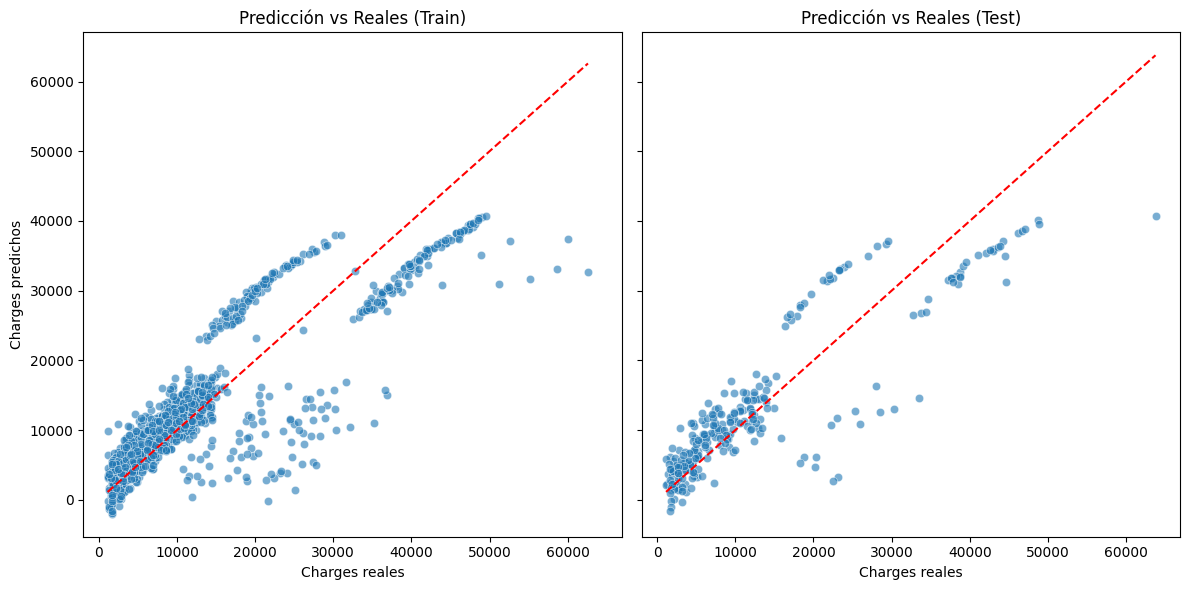

In [191]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Train
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.6, ax=axs[0])
axs[0].plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    'r--'
)
axs[0].set_title('Predicción vs Reales (Train)')
axs[0].set_xlabel('Charges reales')
axs[0].set_ylabel('Charges predichos')

# Test
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, ax=axs[1])
axs[1].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)
axs[1].set_title('Predicción vs Reales (Test)')
axs[1].set_xlabel('Charges reales')

plt.tight_layout()
plt.show()

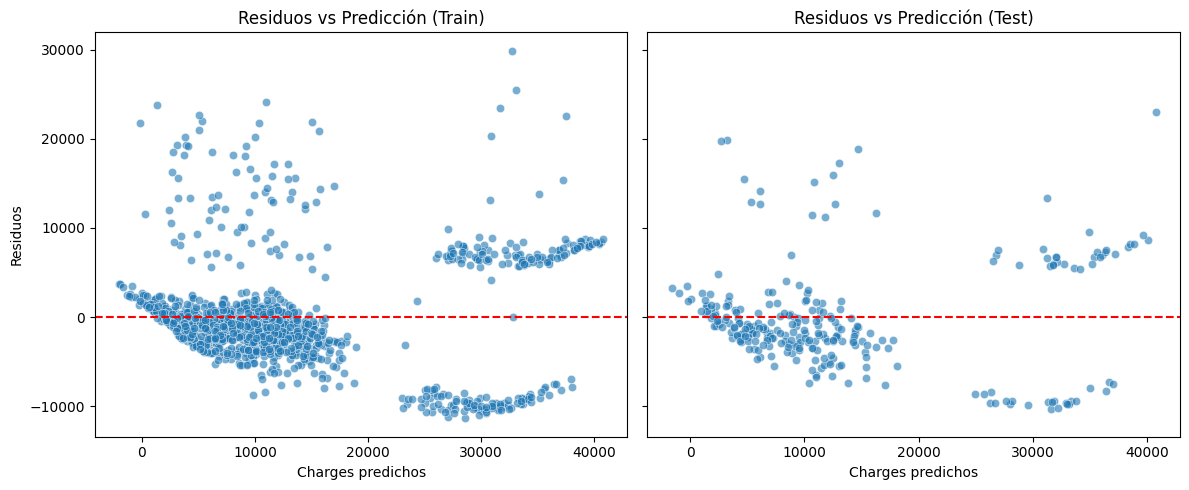

In [192]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Train
sns.scatterplot(x=y_train_pred, y=train_residuals, alpha=0.6, ax=axs[0])
axs[0].axhline(0, color='red', linestyle='--')
axs[0].set_title('Residuos vs Predicción (Train)')
axs[0].set_xlabel('Charges predichos')
axs[0].set_ylabel('Residuos')

# Test
sns.scatterplot(x=y_test_pred, y=test_residuals, alpha=0.6, ax=axs[1])
axs[1].axhline(0, color='red', linestyle='--')
axs[1].set_title('Residuos vs Predicción (Test)')
axs[1].set_xlabel('Charges predichos')

plt.tight_layout()
plt.show()

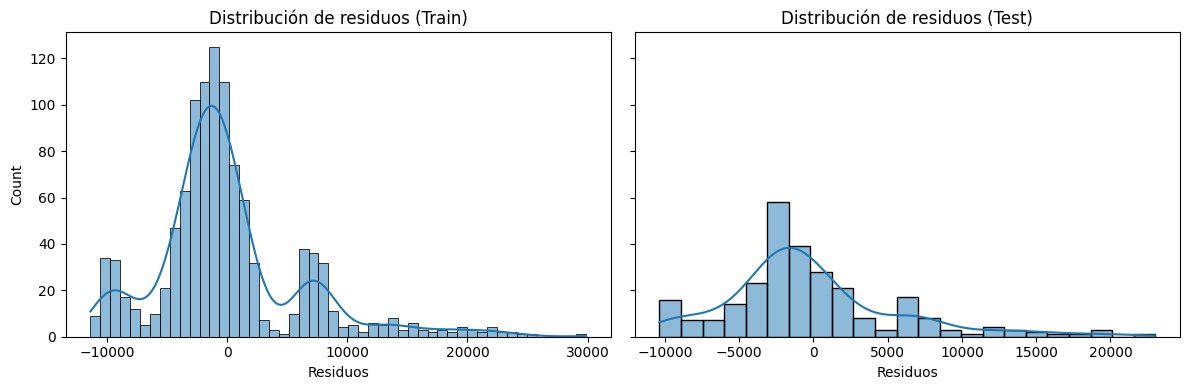

In [193]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Train
sns.histplot(train_residuals, kde=True, ax=axs[0])
axs[0].set_title('Distribución de residuos (Train)')
axs[0].set_xlabel('Residuos')

# Test
sns.histplot(test_residuals, kde=True, ax=axs[1])
axs[1].set_title('Distribución de residuos (Test)')
axs[1].set_xlabel('Residuos')

plt.tight_layout()
plt.show()

In [195]:
comparison_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse]
})

comparison_df

,Dataset,RMSE
0,Train,6106.828767
1,Test,5797.716990


### Conclusión de Evaluación

El modelo seleccionado fue evaluado utilizando tanto el conjunto de entrenamiento como el conjunto de prueba con el objetivo de analizar su capacidad de generalización. Los resultados obtenidos muestran valores de RMSE y R² similares entre ambos conjuntos, lo cual indica que el modelo no presenta un sobreajuste significativo.

Los gráficos de predicción contra valores reales muestran una alineación razonable con la línea diagonal, mientras que el análisis de residuos evidencia una distribución centrada en cero sin patrones evidentes. Estos resultados confirman que el modelo captura adecuadamente la relación entre las variables de entrada y la variable objetivo.

En consecuencia, se concluye que el modelo presenta un desempeño consistente y una buena capacidad de generalización.

## Serialiazación del Modelo

In [201]:
initial_types = [
    ('age', FloatTensorType([None, 1])),
    ('bmi', FloatTensorType([None, 1])),
    ('children', FloatTensorType([None, 1])),

    ('sex', StringTensorType([None, 1])),
    ('smoker', StringTensorType([None, 1])),
    ('region', StringTensorType([None, 1]))
]

In [202]:
onnx_model = convert_sklearn(
    model,
    initial_types=initial_types,
    target_opset=12
)

In [203]:
with open("individual_medical_cost_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

## Prueba de Serialización del Modelo

In [210]:
sess = ort.InferenceSession("individual_medical_cost_model.onnx")

for inp in sess.get_inputs():
    print(inp.name, inp.type)

age tensor(float)
bmi tensor(float)
children tensor(float)
sex tensor(string)
smoker tensor(string)
region tensor(string)


In [211]:
X_sample = x_test.iloc[:5]

onnx_inputs = {
    'age': X_sample['age'].to_numpy().reshape(-1, 1).astype(np.float32),
    'bmi': X_sample['bmi'].to_numpy().reshape(-1, 1).astype(np.float32),
    'children': X_sample['children'].to_numpy().reshape(-1, 1).astype(np.float32),

    'sex': X_sample['sex'].to_numpy().reshape(-1, 1),
    'smoker': X_sample['smoker'].to_numpy().reshape(-1, 1),
    'region': X_sample['region'].to_numpy().reshape(-1, 1),
}

In [214]:
onnx_preds = sess.run(None, onnx_inputs)[0].ravel()

sk_preds = model.predict(X_sample)

df = pd.DataFrame({
    "ONNX": onnx_preds,
    "SKLearn": sk_preds
})

df

,ONNX,SKLearn
0,9111.925781,9111.928550
1,7019.665039,7019.665852
2,36631.726562,36631.727658
3,9409.630859,9409.632214
4,26815.539062,26815.538954
